In [1]:
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import cross_val_score
import warnings
from tqdm import tqdm
import ctg_hyperparam
from joblib import Parallel,delayed
warnings.filterwarnings("ignore")

class ACO_R:
    def __init__(self,X,y,estimator,search_space,cv=5,num_ants=100,q=10,evaporation=0.3,max_iter=10,n_jobs=None,scoring='neg_mean_squared_error',ctg_hyperparames=None) -> None:
        self.X = X
        self.y = y
        self.estimator = estimator
        self.search_space = search_space
        self.cv = cv
        self.scoring = scoring  
        self.num_ants = num_ants
        self.Dimension = len(self.search_space)
        self.S = [[0 for i in range(self.Dimension)] for j in range(self.num_ants)]
        self.q = q
        self.n_jobs = n_jobs
        self.sols_tokeep = num_ants
        self.max_iter = max_iter
        self.num_iter = 0
        self.evaporation = evaporation 
        self.prob = np.zeros(self.sols_tokeep)
        self.best_sol = None
        self.best_score = None
        self.best_sol_list = np.zeros((self.sols_tokeep,self.Dimension))
        self.best_score_list = np.zeros(self.sols_tokeep)
        self.W = np.ones(self.sols_tokeep)
        if (ctg_hyperparames == None):
            self.Ctg_HyperParam = ctg_hyperparam.Ctg_HyperParam[self.estimator]
        else:
            self.Ctg_HyperParam = ctg_hyperparames

    def parameter_desifer(self,sol) -> dict:
        param = {}
        for i,key in enumerate(self.search_space.keys()):
            if "length_" in key:
                continue
            if self.search_space[key]['type'] == 'tuple':
                index = list(self.search_space.keys()).index("length_"+key)
                tmp = []
                for k in range(int(sol[index])):
                    tmp.append(int(sol[i][k]))
                tmp = np.array(tmp)
            if self.search_space[key]['type']=='ctg':
                param[key] = self.Ctg_HyperParam[key][int(sol[i])]
            elif self.search_space[key]['type']=='int':
                param[key] = int(sol[i])
            else:
                param[key] = sol[i]
        return param
    
    def fitness_func(self,param):
        try :
            params = self.parameter_desifer(param)
            model = self.estimator(**params)
            return np.mean(np.abs(cross_val_score(model,self.X,self.y,cv=self.cv,scoring=self.scoring,n_jobs=self.n_jobs)))
        except ValueError as err:
            raise Exception('error ',err)

    
    def Stoping_condition(self):
        if self.num_iter >= self.max_iter:
            return True
        else:
            return False
    

    def init_indv(self,i):
        for j,key in enumerate(self.search_space.keys()):
            ## tuple case
            if self.search_space[key]["type"] == 'tuple':
                tmp = []
                len_key = "length_"+key
                len_index = list(self.search_space.keys()).index(len_key)
                for k in range(int(self.S[i][len_index])):
                    tmp.append(int(random.uniform(self.search_space[key]['range'][0],self.search_space[key]['range'][1])))
                tmp = np.array(tmp)
                self.S[i][j] = tuple(tmp)
            # float case
            elif self.search_space[key]["type"] == 'int' or self.search_space[key]["type"]=='ctg':
                self.S[i][j] = random.randint(self.search_space[key]['range'][0],
                                                 self.search_space[key]['range'][1])
            #int and ctg case
            else:
                self.S[i][j] = random.uniform(self.search_space[key]['range'][0],
                                                 self.search_space[key]['range'][1])
    
    def init_pop(self):
        for i in range(self.num_ants):
            self.init_indv(i)
    

    def init_W(self):
        for i in range(1,self.sols_tokeep+1):
            self.W[i-1] = 1/(self.q*self.sols_tokeep*np.sqrt(2*np.pi))*np.exp(-((i-1)**2)/(2*self.q**2*self.sols_tokeep**2))
    

    def calculate_prob(self):
        sum_W = np.sum(self.W)
        for i in range(self.sols_tokeep):
            self.prob[i] = self.W[i]/sum_W
    
    def choose_index(self,prob):
        return np.random.choice(range(self.sols_tokeep),p=self.prob)
    

    def get_ctg_param_selection(self,var_index,var_val):
        n=len(self.best_sol_list)
        u=0
        best_index = -1
        best_score = np.inf
        for i in range(len(self.best_sol_list)):
            if self.best_sol_list[i][var_index] == var_val:
                u+=1
                n-=1
                if self.best_score_list[i] < best_score:
                    best_score = self.best_score_list[i]
                    best_index = i
        return best_index,n,u


    def choose_ctg_var(self,var_index):
        W=[]
        for i in range(self.search_space[list(self.search_space.keys())[var_index]]['range'][0],self.search_space[list(self.search_space.keys())[var_index]]['range'][1]+1):
            best_index,n,u = self.get_ctg_param_selection(var_index,i)
            if u==0:
                W.append(self.q/n)
            elif n==0 and u>0:
                W.append(self.W[best_index]/u)
            else:
                W.append(self.W[best_index]/u + self.q/n)
        W = np.array(W)
        prob = W/np.sum(W)
        return np.random.choice(range(self.search_space[list(self.search_space.keys())[var_index]]['range'][0],
                                      self.search_space[list(self.search_space.keys())[var_index]]['range'][1]+1),
                                      p=prob)
        
    
    # def gaussian(self,x,mu,sigma):
    #     return 1/(sigma*np.sqrt(2*np.pi))*np.exp(-((x-mu)**2)/(2*sigma**2))
    # def testing(self):
    #     self.init_pop()
    #     self.init_W()
    #     self.best_score_list = np.array([self.fitness_func(self.S[i]) for i in range(self.num_ants)])
    #     best_sols_index = np.array(list(np.argsort(self.best_score_list))[:self.sols_tokeep])
    #     self.best_sol_list = self.S[best_sols_index]
    #     self.best_score_list = self.best_score_list[best_sols_index]
    #     stds = np.zeros(self.Dimension)
    #     selected_sol = self.best_sol_list[0]
    #     for i in range(self.sols_tokeep):
    #         for j in range(self.Dimension):
    #             stds[j] += np.abs(selected_sol[j]-self.best_sol_list[i][j])
    #     stds = self.evaporation*stds/(self.sols_tokeep-1)

    #     for j in range(self.Dimension):
    #         print("std",stds[j])
    #         print(selected_sol[j])
    #         print(stds[j]*np.random.uniform(0,1)+selected_sol[j])

    def fit(self):
        self.init_pop()
        self.init_W()
        progress_bar = tqdm(total=self.max_iter, desc="ACO_R Progress")
        # self.best_score_list = np.array([self.fitness_func(self.S[i]) for i in range(self.num_ants)])
        best_score_list_tmp = Parallel(n_jobs=self.n_jobs)(
            delayed(self.fitness_func)(
                self.S[i]) for i in range(self.num_ants))
        
        self.best_score_list = np.array(best_score_list_tmp)
        
        best_sols_index = np.array(list(np.argsort(self.best_score_list))[:self.sols_tokeep])
        tmp = []
        for i in best_sols_index:
            tmp.append(self.S[i])
        self.best_sol_list = tmp
        self.best_score_list = self.best_score_list[best_sols_index]
        self.calculate_prob()
        while not(self.Stoping_condition()):
            stds = [0 for i in range(self.Dimension)]
            selected_index = self.choose_index(self.prob)
            selected_sol = self.best_sol_list[selected_index]
            for i in range(self.sols_tokeep):
                for j in range(self.Dimension):
                    if self.search_space[list(self.search_space.keys())[j]]['type'] in ['tuple','list']:
                        tmp = []
                        len_key = "length_"+list(self.search_space.keys())[j]
                        len_index = list(self.search_space.keys()).index(len_key)
                        # for k in range(int(self.best_sol_list[i][len_index])):
                        #     tmp.append(np.abs(selected_sol[j][k]-self.best_sol_list[i][j][k]))
                        # tmp = np.array(tmp)
                        if type(stds[j]) == int or type(stds[j]) == float:
                            stds[j]=[]
                            for k in range(int(selected_sol[len_index])):
                                if k< selected_sol[len_index]:
                                    selected_sol_param = selected_sol[j][k]
                                else:
                                    selected_sol_param = random.randint(self.search_space[list(self.search_space.keys())[j]]['range'][0],
                                                                            self.search_space[list(self.search_space.keys())[j]]['range'][1])
                                if k < self.best_sol_list[i][len_index]:
                                    best_sol_param = self.best_sol_list[i][j][k]
                                else:
                                    best_sol_param = random.randint(self.search_space[list(self.search_space.keys())[j]]['range'][0],
                                                                            self.search_space[list(self.search_space.keys())[j]]['range'][1])
                                stds[j].append(self.evaporation*np.abs(selected_sol_param-best_sol_param)/(self.sols_tokeep-1))
                                
                        else:
                            for k in range(int(selected_sol[len_index])):
                                if k< selected_sol[len_index]:
                                    selected_sol_param = selected_sol[j][k]
                                else:
                                    selected_sol_param = random.randint(self.search_space[list(self.search_space.keys())[j]]['range'][0],
                                                                            self.search_space[list(self.search_space.keys())[j]]['range'][1])
                                if k < self.best_sol_list[i][len_index]:
                                    best_sol_param = self.best_sol_list[i][j][k]
                                else:
                                    best_sol_param = random.randint(self.search_space[list(self.search_space.keys())[j]]['range'][0],
                                                                            self.search_space[list(self.search_space.keys())[j]]['range'][1])
                                stds[j][k]+=self.evaporation*np.abs(selected_sol_param-best_sol_param)/(self.sols_tokeep-1)
                        
                    else:
                        stds[j] += self.evaporation*np.abs(selected_sol[j]-self.best_sol_list[i][j])/(self.sols_tokeep-1)
            S_tmp = [[0 for i in range(self.Dimension)] for j in range(self.num_ants)]
            for i in range(self.num_ants):
                for j in range(self.Dimension):
                    ## tuple case
                    if self.search_space[list(self.search_space.keys())[j]]['type'] in ['tuple','list']:
                        tmp = []
                        len_key = "length_"+list(self.search_space.keys())[j]
                        len_index = list(self.search_space.keys()).index(len_key)
                        for k in range(int(S_tmp[i][len_index])):
                            # if k < len(self.S[i][j]):
                            #     tmp.append(int(self.S[i][j][k]+np.random.uniform(0,1)*stds[j][k]))
                            # else :
                            #     tmp.append(int(np.random.uniform(self.search_space[list(self.search_space.keys())[j]]['range'][0],
                            #                      self.search_space[list(self.search_space.keys())[j]]['range'][1])+np.random.uniform(0,1)*stds[j][k]))
                            if k < len(selected_sol[j]):
                                S_j_param = self.S[i][j][k]
                            else:
                                S_j_param = int(np.random.uniform(self.search_space[list(self.search_space.keys())[j]]['range'][0],
                                                 self.search_space[list(self.search_space.keys())[j]]['range'][1]))
                            if k < len(stds[j]):
                                std_jk = stds[j][k]
                            else:
                                std_jk = 0
                            tmp.append(int(S_j_param+np.random.uniform(0,1)*std_jk))
                        for k in range(len(tmp)):
                            if tmp[k] < self.search_space[list(self.search_space.keys())[j]]['range'][0]:
                                tmp[k] = self.search_space[list(self.search_space.keys())[j]]['range'][0]
                            elif tmp[k] > self.search_space[list(self.search_space.keys())[j]]['range'][1]:
                                tmp[k] = self.search_space[list(self.search_space.keys())[j]]['range'][1]
                        S_tmp[i][j] = tuple(tmp)
                    else:
                        if self.search_space[list(self.search_space.keys())[j]]['type']=='ctg':
                            S_tmp[i][j] = self.choose_ctg_var(j)
                        ## int case
                        elif self.search_space[list(self.search_space.keys())[j]]['type']=='int':
                            S_tmp[i][j] = int(self.S[i][j]+np.random.uniform(0,1)*stds[j])
                        else:
                            S_tmp[i][j] = self.S[i][j]+np.random.uniform(0,1)*stds[j]
                        if S_tmp[i][j] < self.search_space[list(self.search_space.keys())[j]]['range'][0]:
                            S_tmp[i][j] = self.search_space[list(self.search_space.keys())[j]]['range'][0]
                        elif S_tmp[i][j] > self.search_space[list(self.search_space.keys())[j]]['range'][1]:
                            S_tmp[i][j] = self.search_space[list(self.search_space.keys())[j]]['range'][1]
            
            # self.best_score_list = np.array([self.fitness_func(self.S[i]) for i in range(self.num_ants)])
            # best_sols_tmp = np.array([self.fitness_func(S_tmp[i]) for i in range(self.num_ants)])
            best_sols_tmp = np.array(Parallel(n_jobs=self.n_jobs)
                                     (delayed(self.fitness_func)(S_tmp[i]) 
                                      for i in range(self.num_ants)))
            self.S = self.S+S_tmp

            self.best_score_list = np.concatenate((self.best_score_list,best_sols_tmp))
            
            best_sols_index = np.array(list(np.argsort(self.best_score_list))[:self.sols_tokeep])
            tmp = []
            for i in best_sols_index:
                tmp.append(self.S[i])
            self.best_sol_list = tmp
            self.best_score_list = self.best_score_list[best_sols_index]
            self.S = self.best_sol_list
            self.calculate_prob()
            self.num_iter+=1
            progress_bar.update(1)
        return {
            "best_params":self.S[0],
            'best_score':self.best_score_list[0]
        }


In [2]:
data = pd.read_csv('reg.csv')
from sklearn.neural_network import MLPRegressor
X = data.iloc[:,:-1].values
y = data.iloc[:,-1].values
search = { 
  "length_hidden_layer_sizes": {"type":"int", "range":[1, 3]},
  'hidden_layer_sizes': {"type":"tuple", "range":[10, 110]},
  'max_iter': {"type":"int", "range":[400, 1000]},
  'activation': {"type":"ctg", "range":[0,3]},
  'solver': {"type":"ctg", "range":[0,2]},
  'alpha': {"type":"float", "range":[0.0001, 0.9]},
  'learning_rate': {"type":"ctg", "range":[0,2]}
}
estimator = MLPRegressor
aco = ACO_R(X=X,y=y,search_space=search,estimator=estimator,num_ants=100,q=10,evaporation=0.3,max_iter=10,n_jobs=-1,scoring='neg_mean_squared_error')
best = aco.fit()

ACO_R Progress: 100%|██████████| 10/10 [12:09<00:00, 72.98s/it]


In [4]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=42)

score against training dataset 0.47955780750384713
score against test dataset 0.5686908287329826


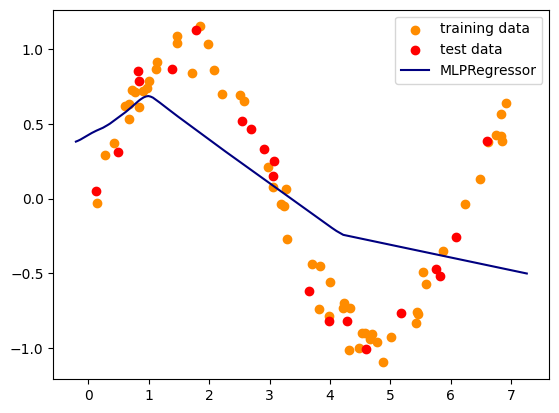

In [7]:
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt

clf = MLPRegressor()
clf.fit(x_train, y_train)
train_score = clf.score(x_train, y_train)
print("score against training dataset {}".format(train_score))
test_score = clf.score(x_test, y_test)
print("score against test dataset {}".format(test_score))
plt.figure()
plt.scatter(x_train, y_train, color='darkorange', label='training data')
plt.scatter(x_test, y_test, color='red',label='test data')
# calculer la prédiction des points du plan
nx = 200
x_min, x_max = plt.xlim()
xx = np.linspace(x_min, x_max, nx)
yy = clf.predict(xx.reshape(-1, 1))
plt.plot(xx, yy, color='navy', label='MLPRegressor')
plt.legend()
plt.show()

score against training dataset 0.9831865254973046
score against test dataset 0.975820925356595


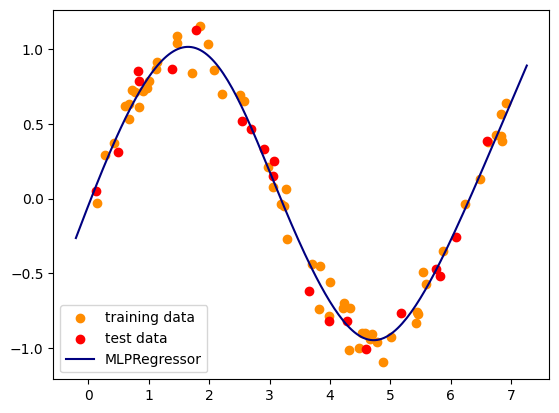

In [8]:
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
param = aco.parameter_desifer(best['best_params'])

clf = MLPRegressor(**param)
clf.fit(x_train, y_train)
train_score = clf.score(x_train, y_train)
print("score against training dataset {}".format(train_score))
test_score = clf.score(x_test, y_test)
print("score against test dataset {}".format(test_score))
plt.figure()
plt.scatter(x_train, y_train, color='darkorange', label='training data')
plt.scatter(x_test, y_test, color='red',label='test data')
# calculer la prédiction des points du plan
nx = 200
x_min, x_max = plt.xlim()
xx = np.linspace(x_min, x_max, nx)
yy = clf.predict(xx.reshape(-1, 1))
plt.plot(xx, yy, color='navy', label='MLPRegressor')
plt.legend()
plt.show()

In [9]:
print(param)

{'hidden_layer_sizes': (100,), 'max_iter': 628, 'activation': 'tanh', 'solver': 'lbfgs', 'alpha': 0.03940179941477989, 'learning_rate': 'constant'}
